In [1]:
import os
import metnum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- pybind11 v2.6.0 
-- Found PythonInterp: /home/lggomez/.pyenv/versions/metnum-tp2/bin/python (found version "3.6.5") 
-- Found PythonLibs: /home/lggomez/.pyenv/versions/3.6.5/lib/libpython3.6m.a
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
CMAKE_INSTALL_PREFIX=/home/lggomez/workspace/facultad/metnum/metodos-num/tp2
-- Configuring done
-- Generating done
-- Build files have been written to: /home/lggomez/wo

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/home/lggomez/workspace/facultad/metnum/metodos-num/tp2/notebooks
Python 3.6.5


In [4]:
%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")

In [5]:
df_train = df_train[:10000]

In [6]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]]
y = df_train["label"]

X.shape, y.shape

((10000, 784), (10000,))

In [7]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 8000 instancias de entrenamiento y 2000 de validación


## Explorando los datos

In [8]:
data_files = os.listdir('knn_pca_results')

def load_files(filenames):
    for filename in filenames:
        yield pd.read_csv(f"knn_pca_results/{filename}")

data = pd.concat(load_files(data_files), ignore_index=True)

data.describe()

,train_size,knn,alpha,kfold,accuracy,recall,f1,cohen_kappa,precision
count,57200.000000,57200.000000,57200.000000,57200.000000,57200.000000,57200.000000,57200.000000,57200.000000,57200.000000
mean,5000.000000,26.000000,60.000000,15.000000,0.906674,0.906674,0.906783,0.895897,0.914114
std,2236.087524,15.000131,31.623053,5.000044,0.034997,0.034997,0.034748,0.039092,0.029033
min,2000.000000,1.000000,10.000000,5.000000,0.750000,0.750000,0.745416,0.721697,0.752244
25%,3500.000000,13.000000,30.000000,10.000000,0.886667,0.886667,0.886218,0.873606,0.895860
50%,5000.000000,26.000000,60.000000,15.000000,0.913750,0.913750,0.913792,0.903912,0.918999
75%,6500.000000,39.000000,90.000000,20.000000,0.932500,0.932500,0.932598,0.924829,0.935769
max,8000.000000,51.000000,110.000000,20.000000,0.976667,0.976667,0.976728,0.973998,0.977210


## Análisis

In [18]:
# mejor pareja, global, por métrica

grouped = data.groupby(['train_size', 'knn', 'alpha', 'kfold']).mean()

idx = []
metrics = grouped.columns.values

for metric in metrics:
    print(f"Media más alta para {metric}")
    idx = grouped[[metric]].idxmax()[metric]
    print(idx, grouped.loc[idx][metric])
    print("==================")

Media más alta para accuracy
(8000, 5, 50, 20) 0.95225
Media más alta para recall
(8000, 5, 50, 20) 0.95225
Media más alta para f1
(8000, 5, 50, 20) 0.9522671387050359
Media más alta para cohen_kappa
(8000, 5, 50, 20) 0.9468069330261057
Media más alta para precision
(8000, 5, 50, 20) 0.9539611710171696


In [20]:
# mejor pareja, por instancia de k-fold, por accuracy

grouped = data.groupby(['kfold', 'knn', 'alpha', 'train_size']).mean()

k = [5, 10, 15, 20]

for i in k:
    df = grouped.loc[i]
    idx = df[['accuracy']].idxmax()['accuracy']
    print(i, idx, df.loc[idx]['accuracy'])
    print("==================")

5 (3, 40, 8000) 0.95
10 (3, 40, 8000) 0.95075
15 (3, 40, 8000) 0.9516207461123876
20 (5, 50, 8000) 0.95225


In [11]:
def getacc(a, k):
    pca = metnum.PCA(a)
    pca.fit(X_train)
    X_train_pca, X_val_pca = pca.transform(X_train), pca.transform(X_val)

    knn = metnum.KNNClassifier(k)
    knn.fit(X_train_pca, y_train)
    knn.load(X_val_pca)
    y_pred = knn.predict(k)

    return accuracy_score(y_val, y_pred)

print(getacc(40, 3))
print(getacc(50, 5))

0.9645
0.9625


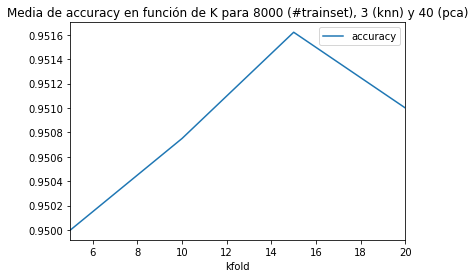

In [21]:
knn=3
pca=40

grouped = data.groupby(['knn', 'alpha', 'train_size', 'kfold']).mean()[['accuracy']]
grouped.loc[knn, pca, 8000].plot(title=f"Media de accuracy en función de K para {8000} (#trainset), {knn} (knn) y {pca} (pca)")

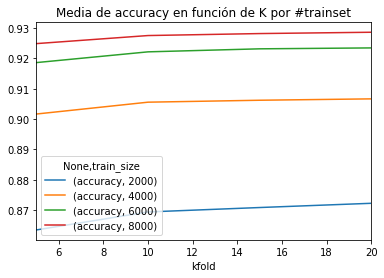

In [22]:
grouped = data.groupby(['kfold', 'train_size']).mean()[['accuracy']]
grouped.unstack(level=1).plot(title="Media de accuracy en función de K por #trainset")

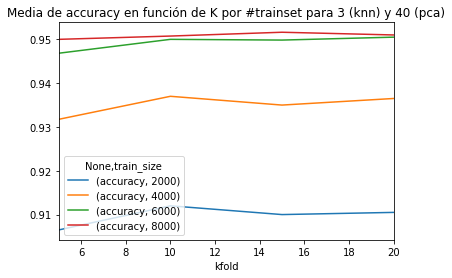

In [23]:
knn=3
pca=40

grouped = data.groupby(['knn', 'alpha', 'kfold', 'train_size']).mean()[['accuracy']]
grouped.loc[knn, pca].unstack(level=1).plot(title=f"Media de accuracy en función de K por #trainset para {knn} (knn) y {pca} (pca)")